# Experiment 4: GMM Clustering after PCA Dimensionality Reduction

## Imports and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%cd ..
from src.models.pca import PCA
from src.models.gmm import GMM, Covariance
from src.utils.metrics import *
from src.utils.utils import *

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

c:\Users\ziade\OneDrive\Desktop\Term 7\ML\Lab 4\Assignment4-Unsupervised-Clustering-Analysis


## Data Loading and Preprocessing

In [2]:
X_scaled, y_true = load_scale_data(data_path='./data/breast_cancer.csv')

print(f"Dataset shape: {X_scaled.shape}")
print(f"Labels shape: {y_true.shape}")

Dataset shape: (569, 30)
Labels shape: (569,)


## Running PCA-GMM

In [3]:
dims = [2, 5, 10, 15, 20]
cov_types = [Covariance.FULL, Covariance.TIED, Covariance.DIAGONAL, Covariance.SPHERICAL]
gmm_pca_results = []

for d in dims:
    pca = PCA(n_components=d)
    X_pca = pca.fit_transform(X_scaled)
    
    for cov_t in cov_types:
        # Fit GMM (k=2 for binary classification)
        gmm = GMM(k=2, covariance_type=cov_t, max_iter=100)
        gmm.fit(X_pca)
        y_pred = gmm.predict(X_pca)
        
        # Calculate external metrics
        ari = compute_ari(y_true, y_pred)
        
        gmm_pca_results.append({
            'Dimensions': d,
            'Covariance': cov_t.value,
            'Log-Likelihood': gmm.log_likelihood_[-1],
            'ARI': ari,
            'BIC': gmm.bic(X_pca)
        })

gmm_df = pd.DataFrame(gmm_pca_results)
gmm_df

,Dimensions,Covariance,Log-Likelihood,ARI,BIC
0,2,full,-2672.468461,0.632548,5414.719606
1,2,tied,-2795.561820,0.058458,5641.874684
2,2,diagonal,-2680.089807,0.621306,5417.274538
3,2,spherical,-2681.734466,0.615591,5407.876095
4,5,full,-5471.894119,0.401536,11203.887335
5,5,tied,-5703.076638,0.372407,11571.094167
6,5,diagonal,-5622.299403,0.415050,11377.820296
7,5,spherical,-5780.693399,0.631791,11643.857244
8,10,full,-7960.009437,0.349266,16751.067212
9,10,tied,-8369.095052,0.471302,17220.325018


## Visualizing Covariance Type Impact

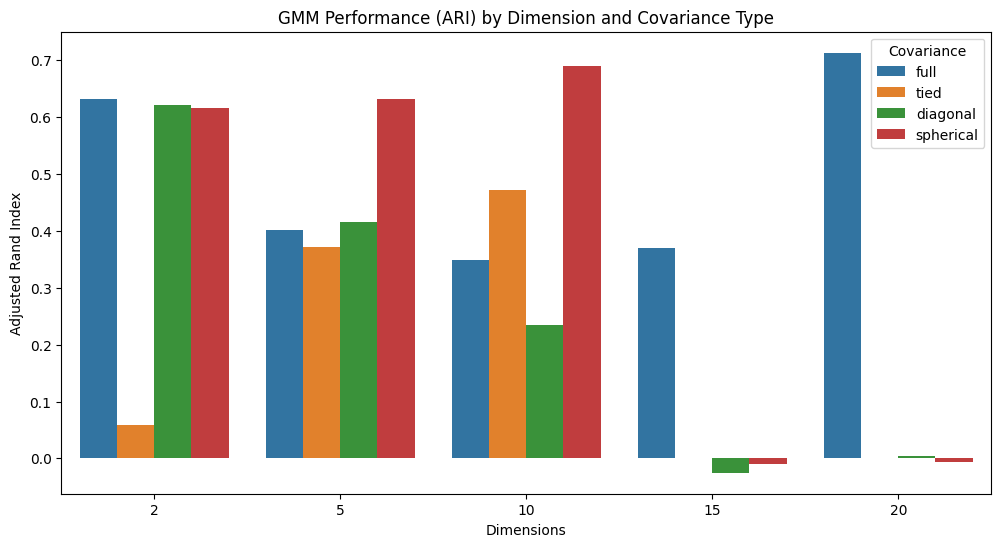

In [4]:
plt.figure(figsize=(12, 6))
sns.barplot(data=gmm_df, x='Dimensions', y='ARI', hue='Covariance')
plt.title("GMM Performance (ARI) by Dimension and Covariance Type")
plt.ylabel("Adjusted Rand Index")
plt.show()

## Log-Likelihood Convergence Analysis by Dimension

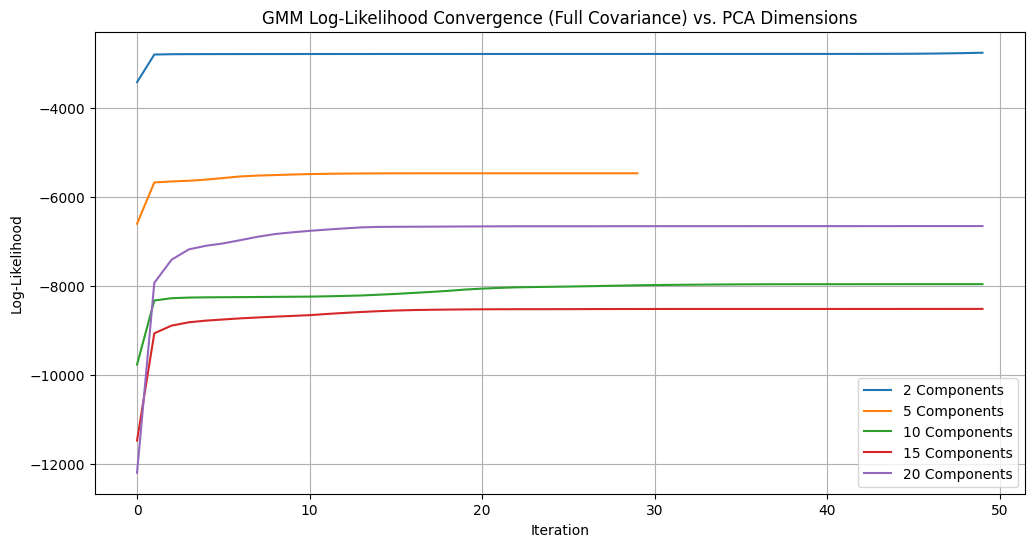

In [5]:
plt.figure(figsize=(12, 6))

for d in dims:
    pca = PCA(n_components=d)
    X_pca = pca.fit_transform(X_scaled)
    
    gmm = GMM(k=2, covariance_type=Covariance.FULL, max_iter=50)
    gmm.fit(X_pca)
    
    plt.plot(gmm.log_likelihood_, label=f'{d} Components')

plt.title("GMM Log-Likelihood Convergence (Full Covariance) vs. PCA Dimensions")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()

## BIC/AIC Heatmap for Covariance Analysis

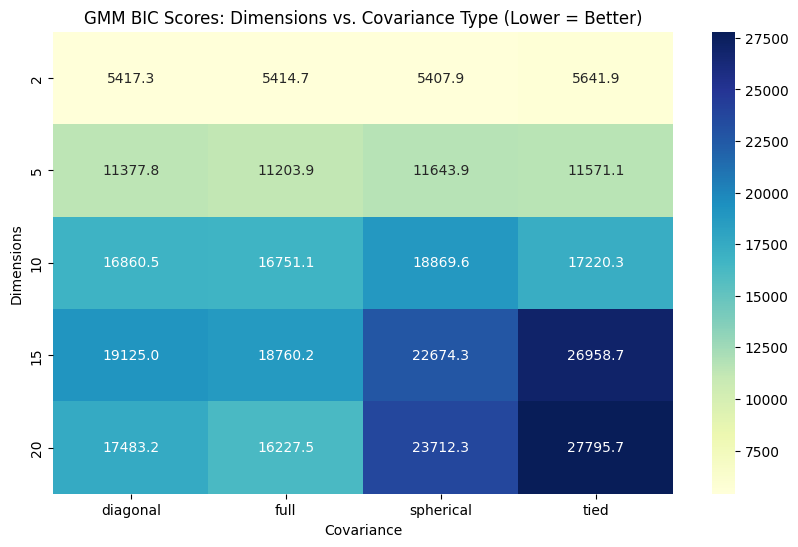

In [6]:
pivot_bic = gmm_df.pivot(index="Dimensions", columns="Covariance", values="BIC")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_bic, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("GMM BIC Scores: Dimensions vs. Covariance Type (Lower = Better)")
plt.show()

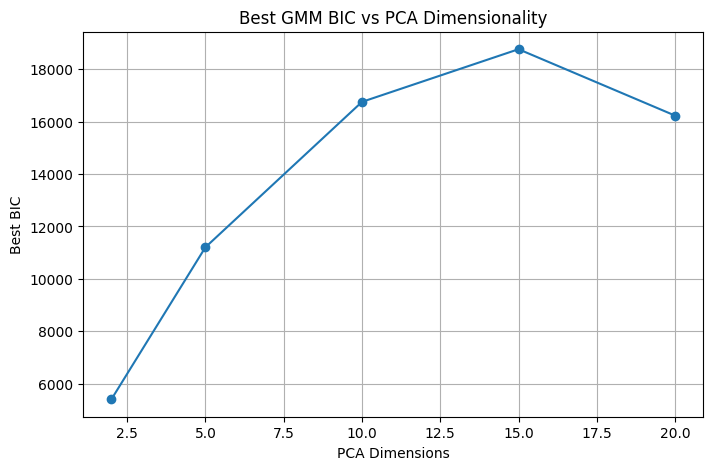

In [7]:
best_cov_per_dim = gmm_df.loc[gmm_df.groupby('Dimensions')['BIC'].idxmin()]

plt.figure(figsize=(8, 5))
plt.plot(
    best_cov_per_dim['Dimensions'],
    best_cov_per_dim['BIC'],
    marker='o'
)
plt.xlabel("PCA Dimensions")
plt.ylabel("Best BIC")
plt.title("Best GMM BIC vs PCA Dimensionality")
plt.grid(True)
plt.show()


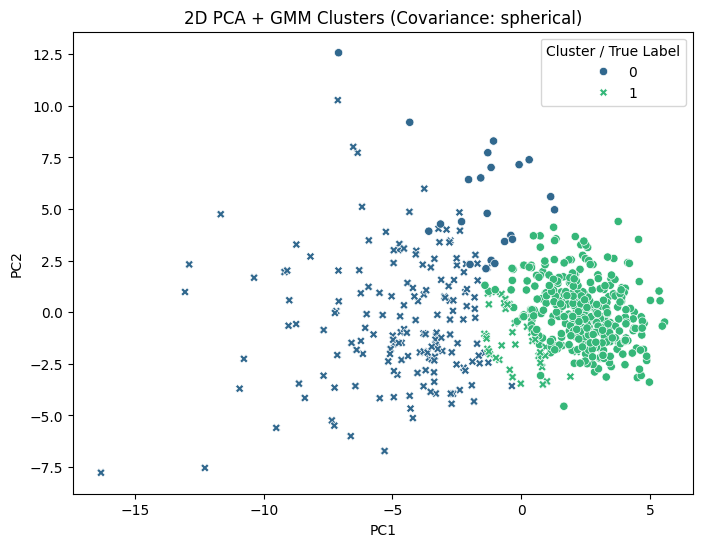

In [8]:
# 2D PCA visualization with GMM clustering (best covariance example)

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

best_cov = pivot_bic.loc[2].idxmin()  # best covariance for 2D PCA
gmm_2d = GMM(k=2, covariance_type=Covariance(best_cov))
gmm_2d.fit(X_2d)
y_2d_pred = gmm_2d.predict(X_2d)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=y_2d_pred,
    palette='viridis',
    style=y_true
)
plt.title(f"2D PCA + GMM Clusters (Covariance: {best_cov})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster / True Label")
plt.show()
